参考链接：

https://zhuanlan.zhihu.com/p/163703984

https://blog.csdn.net/qq_43219379/article/details/123244830

https://zhuanlan.zhihu.com/p/94757947

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

filepath = '/Users/xudongzuo/Library/CloudStorage/OneDrive-个人/文档/workspace/test_data/processed/data_process.csv'
data = pd.read_csv(filepath)

# 打印前几条数据
print(data.head())
# 打印维度
print(data.shape)
data.drop(["is_extract",'smoothing','smoothing','时间戳'], axis=1, inplace=True)
data = data.iloc[:,[0,1,2,3,4,5,-2,-1]]
# 检查是否存在 NaN
print(data.isna().sum())
data = pd.DataFrame(data)
data.fillna(method='ffill', inplace=True)


             时间戳                 运行时间      刀盘转速       推进速度        刀盘扭矩  \
0  1436717717000  2015-07-13 00:15:17  5.021220  14.772656  641.040796   
1  1436717718000  2015-07-13 00:15:18  5.021211  14.111133  661.583728   
2  1436717719000  2015-07-13 00:15:19  5.021203  14.331592  681.453101   
3  1436717721000  2015-07-13 00:15:21  5.021195  14.992969  699.470264   
4  1436717722000  2015-07-13 00:15:22  5.021186  15.654419  712.099109   

        贯入度         总推进力  推进速度给定百分比  刀盘给定转速显示值   推进速度电位器设定值  is_extract  \
0  2.435256  6039.353516  12.310546   5.017798   913.628479        True   
1  2.326148  6210.932129  11.759277   5.017800   913.990112        True   
2  2.362490  6459.779297  11.942993   5.017803   914.713501        True   
3  2.471517  6999.513672  12.494140   5.017808   914.713501        True   
4  2.580557  7300.629395  13.045349   5.017815  1046.368652        True   

   smoothing  cycle_id phase_label  
0       True         1      rising  
1       True         1      ri

/var/folders/2b/lrgpb6l56qq7z0p0v5dqkb7h0000gn/T/ipykernel_9606/3497542893.py:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


In [ ]:
# 控制参数（驾驶员设定）
control_params = ["刀盘转速电位器设定值", "推进速度电位器设定值"]

# 实际参数（传感器测量，需检查数据是否有效）
actual_params = ["刀盘转速", "推进速度", "刀盘扭矩", "贯入度", "总推进力"]

In [2]:
# 定义需要归一化的特征列
features = ['刀盘转速', '刀盘扭矩', '贯入度', '总推进力', "推进速度"]
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])
# 按 cycle_id 分割数据
cycles = data.groupby('cycle_id')

# 提取每个循环的上升段和稳定段数据
cycle_data = []
for cycle_id, group in cycles:
    rising = group[group['phase_label'] == 'rising']
    stable = group[group['phase_label'] == 'stable']
    if not rising.empty and not stable.empty:
        # 提取稳定段的推进速度和刀盘转速平均值
        stable_speed = stable['推进速度'].mean()
        stable_rpm = stable['刀盘转速'].mean()
        # 提取稳定段的目标值（总推力和扭矩的平均值）
        target_thrust = stable['总推进力'].mean()
        target_torque = stable['刀盘扭矩'].mean()
        # 保存为样本
        cycle_data.append({
            'rising_features': rising[features].values,
            'stable_speed': stable_speed,
            'stable_rpm': stable_rpm,
            'target_thrust': target_thrust,
            'target_torque': target_torque
        })

# 固定输入序列长度（根据论文选择50秒）
max_sequence_length = 50

# 处理每个样本的上升段数据
X_sequence = []
X_control = []
y_thrust = []
y_torque = []

'''	每个 sample 通常包含：
	•上升段特征（rising_features），即在上升段时刻收集到的传感器数据序列。
	•稳定段对应的控制参数（stable_speed, stable_rpm）。
	•稳定段对应的目标值（target_thrust, target_torque）。
	这样做可能产生的问题：
	首先是-每段掘进过程仅仅选择五十组数据，剩下的没有利用
'''
for sample in cycle_data:
    seq = sample['rising_features']
    # 填充或截断序列
    if len(seq) < max_sequence_length:
        pad = np.zeros((max_sequence_length - len(seq), seq.shape[1]))
        seq = np.vstack((seq, pad))
    else:
        seq = seq[:max_sequence_length]
    X_sequence.append(seq)
    # 控制参数（推进速度和刀盘转速）
    X_control.append([sample['stable_speed'], sample['stable_rpm']])
    # 目标值
    y_thrust.append(sample['target_thrust'])
    y_torque.append(sample['target_torque'])

# 转换为NumPy数组
X_sequence = np.array(X_sequence)
X_control = np.array(X_control)
y_thrust = np.array(y_thrust)
y_torque = np.array(y_torque)

(1,                      运行时间      刀盘转速      推进速度      刀盘扭矩       贯入度      总推进力  \
0     2015-07-13 00:15:17  0.702426  0.145023  0.136661  0.123133  0.315150   
1     2015-07-13 00:15:18  0.702425  0.138529  0.142088  0.117617  0.324103   
2     2015-07-13 00:15:19  0.702423  0.140693  0.147338  0.119454  0.337089   
3     2015-07-13 00:15:21  0.702422  0.147186  0.152098  0.124967  0.365253   
4     2015-07-13 00:15:22  0.702420  0.153679  0.155434  0.130480  0.380966   
...                   ...       ...       ...       ...       ...       ...   
1562  2015-07-13 00:43:46  0.702773  0.000000  0.436719  0.000000  0.000000   
1563  2015-07-13 00:43:47  0.702838  0.000000  0.353041  0.000000  0.000000   
1564  2015-07-13 00:43:48  0.702895  0.000000  0.267717  0.000000  0.000000   
1565  2015-07-13 00:43:49  0.702944  0.000000  0.199253  0.000000  0.000000   
1566  2015-07-13 00:43:50  0.702986  0.000000  0.150363  0.000000  0.000000   

      cycle_id phase_label  
0            1    

In [5]:
class BLSTMWithAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, control_dim, output_dim, sequence_length, num_layers=2):
        super(BLSTMWithAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.sequence_length = sequence_length

        # BiLSTM 层（输入维度需与数据特征一致）
        self.blstm = nn.LSTM(
            input_size=input_dim,  # 修改为实际特征数5
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )

        # 注意力机制（MultiheadAttention）
        self.attention = nn.MultiheadAttention(
            embed_dim=hidden_dim * 2,  # 双向LSTM输出维度
            num_heads=8,
            batch_first=True
        )

        # 控制参数处理（维度需与输入数据一致）
        self.control_fc = nn.Sequential(
            nn.Linear(control_dim, 32),
            nn.ReLU()
        )

        # 输出层
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim*2 + 32, 64),  # 双向LSTM输出+控制参数
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x, control):
        # BiLSTM处理
        lstm_out, _ = self.blstm(x)  # 输入x应为 [batch, 50, 5]

        # 注意力机制（使用最后一个时间步作为query）
        query = lstm_out[:, -1, :].unsqueeze(1)  # [batch, 1, 128]
        attn_output, _ = self.attention(
            query=query,
            key=lstm_out,
            value=lstm_out
        )  # [batch, 1, 128]
        attn_output = attn_output.squeeze(1)  # [batch, 128]

        # 控制参数处理
        control_out = self.control_fc(control)  # [batch, 32]

        # 特征拼接
        merged = torch.cat([attn_output, control_out], dim=1)  # [batch, 160]

        # 输出预测
        return self.fc(merged)

#============================ 实际数据适配 ============================#
# 模型参数（根据实际数据调整）
input_dim = 5     # 对应['刀盘转速','推进速度','刀盘扭矩','贯入度','总推进力'] 5个特征
hidden_dim = 32
control_dim = 2   # 对应stable_speed和stable_rpm
output_dim = 2    # 预测推力和扭矩
sequence_length = 50  # 与你设置的max_sequence_length一致
batch_size = 256

# 创建模型
model = BLSTMWithAttention(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    control_dim=control_dim,
    output_dim=output_dim,
    sequence_length=sequence_length
)
#============================ 数据转换 ============================#

# 将numpy数组转为PyTorch张量（注意维度匹配）
X_seq_tensor = torch.from_numpy(X_sequence).float()  # [num_samples, 50, 5]
X_ctrl_tensor = torch.from_numpy(X_control).float()  # [num_samples, 2]
y_thrust_tensor = torch.from_numpy(y_thrust).float()
y_torque_tensor = torch.from_numpy(y_torque).float()
# 合并输出（因为模型输出两个值）
y_combined = torch.stack([y_thrust_tensor, y_torque_tensor], dim=1)  # [num_samples, 2]


In [4]:
class BLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, control_dim, output_dim, sequence_length, num_layers=2):
        super(BLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.sequence_length = sequence_length
        self.lstm = nn.LSTM(
            input_size=input_dim, hidden_size=hidden_dim,
        )
    def forward(self, x, control):
        lstm_out, _ = self.lstm(x)



In [83]:
y_combined

tensor([[0.5678, 0.6387],
        [0.5660, 0.5808],
        [0.5427, 0.5775],
        [0.5469, 0.6364],
        [0.4861, 0.4532],
        [0.4994, 0.4720],
        [0.5079, 0.5064],
        [0.5358, 0.6236],
        [0.6238, 0.7761],
        [0.6030, 0.7507],
        [0.6626, 0.7387],
        [0.6677, 0.7860],
        [0.6554, 0.8148],
        [0.6083, 0.7912],
        [0.6840, 0.8135],
        [0.6428, 0.8079],
        [0.6687, 0.7831],
        [0.6827, 0.7097],
        [0.6958, 0.7774],
        [0.5354, 0.6830],
        [0.5110, 0.6690],
        [0.5293, 0.6524],
        [0.4446, 0.5766],
        [0.4113, 0.4815],
        [0.4555, 0.5201],
        [0.5163, 0.5994],
        [0.3947, 0.3021],
        [0.4250, 0.3360],
        [0.4117, 0.3341],
        [0.3871, 0.3801],
        [0.6365, 0.7170],
        [0.6857, 0.7939],
        [0.6634, 0.7827],
        [0.6268, 0.6602],
        [0.5889, 0.7597],
        [0.5949, 0.7615],
        [0.6114, 0.7437],
        [0.6421, 0.7704],
        [0.6

In [6]:
#============================ 数据加载 ============================#
# ============== 假设 X_sequence, X_control, y_combined 已经准备好了 ==============
# 这部分数据是上升段序列 + 控制参数 + 目标值
test_size = 0.2  # 例如留 20% 作为测试集
X_seq_train, X_seq_test, X_ctrl_train, X_ctrl_test, y_train, y_test = \
    train_test_split(X_sequence, X_control, y_combined,
                     test_size=test_size,
                     random_state=42)  # 可以固定随机数种子

# 转换为 Torch 张量
X_seq_train_t = torch.from_numpy(X_seq_train).float()
X_ctrl_train_t = torch.from_numpy(X_ctrl_train).float()
#y_train_t = torch.from_numpy(y_train).float()

X_seq_test_t = torch.from_numpy(X_seq_test).float()
X_ctrl_test_t = torch.from_numpy(X_ctrl_test).float()
#y_test_t = torch.from_numpy(y_test).float()

# 构建 TensorDataset
train_dataset = TensorDataset(X_seq_train_t, X_ctrl_train_t, y_train)
test_dataset  = TensorDataset(X_seq_test_t, X_ctrl_test_t, y_test)

# DataLoader 迭代器
#train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

In [7]:
def calculate_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0  # 避免除以零
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
def inverse_transform_1d(values, scaler, feature_idx, features):
    """
    values:      一维的归一化数值 (如[推力] 或 [扭矩])，shape = [N,]
    scaler:      训练时使用的 MinMaxScaler 对象
    feature_idx: 该列在 features 里的索引
    features:    scaler 对应的特征列表，顺序必须一致
    """
    # 构建一个形状 [N, len(features)] 的零矩阵
    dummy = np.zeros((len(values), len(features)), dtype=np.float32)
    # 将要反归一化的数据放到 dummy 的第 feature_idx 列
    dummy[:, feature_idx] = values
    # 对 dummy 做 inverse_transform，就可以恢复到原始尺度
    dummy_inv = scaler.inverse_transform(dummy)
    # 最后只拿回那一列数据
    return dummy_inv[:, feature_idx]

Epoch [1/100], Train Loss: 0.0379, Test Loss: 0.6506
Epoch [2/100], Train Loss: 0.6985, Test Loss: 0.1347
Epoch [3/100], Train Loss: 0.1319, Test Loss: 0.1623
Epoch [4/100], Train Loss: 0.1545, Test Loss: 0.1106
Epoch [5/100], Train Loss: 0.1103, Test Loss: 0.0969
Epoch [6/100], Train Loss: 0.0776, Test Loss: 0.1240
Epoch [7/100], Train Loss: 0.0887, Test Loss: 0.1364
Epoch [8/100], Train Loss: 0.0988, Test Loss: 0.1223
Epoch [9/100], Train Loss: 0.0855, Test Loss: 0.1128
Epoch [10/100], Train Loss: 0.0849, Test Loss: 0.1144
Epoch [11/100], Train Loss: 0.0915, Test Loss: 0.1113
Epoch [12/100], Train Loss: 0.0855, Test Loss: 0.1094
Epoch [13/100], Train Loss: 0.0807, Test Loss: 0.1110
Epoch [14/100], Train Loss: 0.0796, Test Loss: 0.1152
Epoch [15/100], Train Loss: 0.0809, Test Loss: 0.1183
Epoch [16/100], Train Loss: 0.0821, Test Loss: 0.1167
Epoch [17/100], Train Loss: 0.0810, Test Loss: 0.1122
Epoch [18/100], Train Loss: 0.0790, Test Loss: 0.1083
Epoch [19/100], Train Loss: 0.0786, T

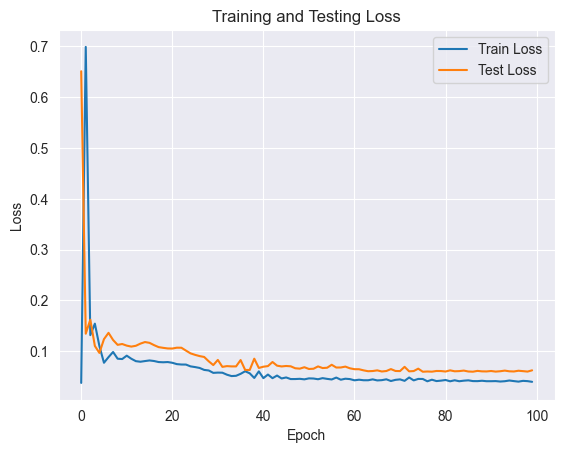

In [13]:
#简洁版
# all_preds:  模型对测试集的预测 (scaled)，shape: [N, 2], 分别对应 [推力, 扭矩]
# all_trues:  测试集的真实值   (scaled)，shape: [N, 2], 分别对应 [推力, 扭矩]
# scaler:     训练时使用的 MinMaxScaler 实例
# features:   与 scaler 对应的特征列表，比如
#             features = ['刀盘转速','刀盘扭矩','贯入度','总推进力','推进速度']
# ----------------------------------------------------
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)   # 通常先用更小的LR
epochs = 100

train_losses = []
test_losses_per_epoch = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    count = 0

    for batch_x, batch_ctrl, batch_y in train_loader:
        # （一次标准的更新）
        optimizer.zero_grad()
        outputs = model(batch_x, batch_ctrl)
        loss = criterion(outputs, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()

        # 累加损失，每个item也就是一个batch的loss
        epoch_loss += loss.item()
        count += 1

    # 计算平均train loss
    avg_epoch_loss = epoch_loss / count

    train_losses.append(avg_epoch_loss)

    # ---------- 测试集评估 -----------
    model.eval()
    tmp_test_loss = 0.0
    test_count = 0
    with torch.no_grad():
        for batch_x, batch_ctrl, batch_y in test_loader:
            pred = model(batch_x, batch_ctrl)
            val_loss = criterion(pred, batch_y)
            tmp_test_loss += val_loss.item()
            test_count += 1
    avg_test_loss = tmp_test_loss / test_count
    test_losses_per_epoch.append(avg_test_loss)

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_epoch_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

# 最终预测
model.eval()
all_preds = []
all_trues = []
with torch.no_grad():
    for batch_x, batch_ctrl, batch_y in test_loader:
        pred = model(batch_x, batch_ctrl)   # shape: [batch_size, 2]
        all_preds.append(pred.cpu().numpy())
        all_trues.append(batch_y.cpu().numpy())

all_preds = np.concatenate(all_preds, axis=0)
all_trues = np.concatenate(all_trues, axis=0)

pred_thrust = all_preds[:, 0]
pred_torque = all_preds[:, 1]
true_thrust = all_trues[:, 0]
true_torque = all_trues[:, 1]

# 3) 找到推力和扭矩在 features 列表里的索引
thrust_idx = features.index('总推进力')
torque_idx = features.index('刀盘扭矩')

# 4) 分别反归一化推力和扭矩（预测值和真实值）
thrust_true_inv = inverse_transform_1d(true_thrust,  scaler, thrust_idx, features)
thrust_pred_inv = inverse_transform_1d(pred_thrust,  scaler, thrust_idx, features)
torque_true_inv = inverse_transform_1d(true_torque,  scaler, torque_idx, features)
torque_pred_inv = inverse_transform_1d(pred_torque,  scaler, torque_idx, features)

# 5) 在原始尺度上重新计算 MSE、MAE
mse_thrust_inv = np.sqrt(mean_squared_error(thrust_true_inv, thrust_pred_inv))
mae_thrust_inv = mean_absolute_error(thrust_true_inv, thrust_pred_inv)
mape_thrust_inv = calculate_mape(thrust_true_inv, thrust_pred_inv)

mse_torque_inv = np.sqrt(mean_squared_error(torque_true_inv, torque_pred_inv))
mae_torque_inv = mean_absolute_error(torque_true_inv, torque_pred_inv)
mape_torque_inv = calculate_mape(torque_true_inv, torque_pred_inv)

print(f"Thrust - MSE: {mse_thrust_inv:.4f}, MAE: {mae_thrust_inv:.4f}, MAPE: {mape_thrust_inv:.4f}")
print(f"Torque - MSE: {mse_torque_inv:.4f}, MAE: {mae_torque_inv:.4f}, MAPE: {mape_torque_inv:.4f}")

# 绘图
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses_per_epoch, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Testing Loss')
plt.show()

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# 假设 model、train_loader、criterion、optimizer 都已经定义
epochs = 1000
train_losses = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    count = 0

    for batch_x, batch_ctrl, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x, batch_ctrl)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        count += 1

    # 计算该 epoch 上的平均损失
    avg_epoch_loss = epoch_loss / count
    train_losses.append(avg_epoch_loss)

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_epoch_loss:.4f}")

# ============ 训练完成后，画出 Loss 曲线 ============
plt.plot(train_losses)         # 画出训练损失列表
plt.xlabel('Epoch')           # x 轴标签
plt.ylabel('Loss')            # y 轴标签
plt.title('Training Loss')    # 图的标题
plt.show()

In [ ]:
#============================ 训练示例 ============================#
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(100):
    for batch_x, batch_ctrl, batch_y in train_loader:
        optimizer.zero_grad()
        # 前向传播
        outputs = model(batch_x, batch_ctrl)  # 输入形状自动匹配

        # 计算损失
        loss = criterion(outputs, batch_y)

        # 反向传播
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)  # 梯度裁剪
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def calculate_metrics(y_true, y_pred):
    """计算多种评估指标"""
    metrics = {
        'MAE': mean_absolute_error(y_true, y_pred),
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R2': r2_score(y_true, y_pred)
    }
    return metrics

def plot_metrics_comparison(metrics_dict, param_name):
    """绘制指标对比条形图"""
    labels = list(metrics_dict.keys())
    values = list(metrics_dict.values())

    plt.figure(figsize=(10, 6))
    bars = plt.bar(labels, values, color=['#4C72B0', '#55A868', '#C44E52', '#8172B2'])

    # 添加数值标签
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.3f}',
                 ha='center', va='bottom')

    plt.title(f'{param_name} Prediction Metrics Comparison', fontsize=14)
    plt.ylabel('Metric Value', fontsize=12)
    plt.xticks(fontsize=10)
    plt.grid(axis='y', alpha=0.3)
    plt.show()

def plot_combined_results(y_true, y_pred, param_name):
    """综合可视化：预测对比 + 误差分布"""
    plt.figure(figsize=(14, 6))

    # 子图1：预测结果对比
    plt.subplot(1, 2, 1)
    plt.scatter(y_true, y_pred, alpha=0.6, c='#2E86C1', edgecolors='w', linewidth=0.5)
    max_val = max(y_true.max(), y_pred.max())
    min_val = min(y_true.min(), y_pred.min())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)

    metrics = calculate_metrics(y_true, y_pred)
    plt.title(f'{param_name} Prediction\nR²: {metrics["R2"]:.3f} | MAE: {metrics["MAE"]:.2f} | RMSE: {metrics["RMSE"]:.2f}')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.grid(alpha=0.3)

    # 子图2：误差分布
    plt.subplot(1, 2, 2)
    errors = y_pred - y_true
    sns.histplot(errors, kde=True, color='#28B463',
                bins=30, edgecolor='w', linewidth=0.5)
    plt.title(f'Error Distribution\n(Mean: {errors.mean():.2f} | Std: {errors.std():.2f})')
    plt.xlabel('Prediction Error')
    plt.ylabel('Frequency')
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

#============================ 完整评估流程 ============================#
def evaluate_model(model, dataloader, scaler, features):
    """完整评估函数"""
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for x, ctrl, y in dataloader:
            outputs = model(x, ctrl)
            all_preds.append(outputs.numpy())
            all_targets.append(y.numpy())

    # 合并结果
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    # 反归一化
    def inverse_transform(data, idx):
        dummy = np.zeros((len(data), len(features)))
        dummy[:, idx] = data
        return scaler.inverse_transform(dummy)[:, idx]

    # 推力评估
    thrust_pred = inverse_transform(all_preds[:, 0], features.index('总推进力'))
    thrust_true = inverse_transform(all_targets[:, 0], features.index('总推进力'))

    # 扭矩评估
    torque_pred = inverse_transform(all_preds[:, 1], features.index('刀盘扭矩'))
    torque_true = inverse_transform(all_targets[:, 1], features.index('刀盘扭矩'))

    # 计算指标
    thrust_metrics = calculate_metrics(thrust_true, thrust_pred)
    torque_metrics = calculate_metrics(torque_true, torque_pred)

    # 可视化
    print("\n推力预测评估:")
    plot_combined_results(thrust_true, thrust_pred, "Thrust")
    plot_metrics_comparison(thrust_metrics, "Thrust")

    print("\n扭矩预测评估:")
    plot_combined_results(torque_true, torque_pred, "Torque")
    plot_metrics_comparison(torque_metrics, "Torque")

    return {
        'thrust': thrust_metrics,
        'torque': torque_metrics
    }



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score


def plot_results(y_true, y_pred, param_name):
    """绘制预测结果对比图"""
    plt.figure(figsize=(10, 6))

    # 散点图展示预测精度
    plt.scatter(y_true, y_pred, alpha=0.6, edgecolors='w', linewidth=0.5)

    # 绘制理想对角线
    max_val = max(y_true.max(), y_pred.max())
    min_val = min(y_true.min(), y_pred.min())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)

    plt.xlabel(f'Actual {param_name}', fontsize=12)
    plt.ylabel(f'Predicted {param_name}', fontsize=12)
    plt.title(f'{param_name} Prediction Performance (R² = {r2_score(y_true, y_pred):.3f})', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_error_distribution(y_true, y_pred, param_name):
    """绘制误差分布图"""
    errors = y_pred - y_true
    plt.figure(figsize=(10, 6))

    sns.histplot(errors, kde=True, bins=30,
                edgecolor='black', linewidth=0.5)

    plt.xlabel(f'Prediction Error ({param_name})', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title(f'{param_name} Error Distribution (MAE = {np.mean(np.abs(errors)):.2f})', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_training_curve(train_losses, val_losses):
    """绘制训练曲线"""
    plt.figure(figsize=(10, 6))

    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')

    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss (MAE)', fontsize=12)
    plt.title('Training and Validation Loss Curves', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

#============================ 扩展训练过程 ============================#
# 初始化存储列表
train_loss_history = []
val_loss_history = []
all_preds = []
all_targets = []

# 训练循环（添加验证集预测）
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = []

    # 训练阶段
    for batch_x, batch_ctrl, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x, batch_ctrl)
        loss = criterion(outputs, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()
        epoch_train_loss.append(loss.item())

    # 验证阶段
    model.eval()
    epoch_val_loss = []
    with torch.no_grad():
        for val_x, val_ctrl, val_y in train_loader:  # 假设已有val_loader
            outputs = model(val_x, val_ctrl)
            loss = criterion(outputs, val_y)
            epoch_val_loss.append(loss.item())

            # 收集预测结果
            all_preds.append(outputs.numpy())
            all_targets.append(val_y.numpy())

    # 记录损失
    train_loss = np.mean(epoch_train_loss)
    val_loss = np.mean(epoch_val_loss)
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

#============================ 数据反归一化 ============================#
# 假设scaler是之前定义的MinMaxScaler对象
def inverse_transform(data, feature_index):
    """反归一化单个特征"""
    dummy = np.zeros((len(data), len(features)))
    dummy[:, feature_index] = data
    return scaler.inverse_transform(dummy)[:, feature_index]

# 合并所有预测结果
all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)

# 反归一化数据
thrust_pred = inverse_transform(all_preds[:, 0], features.index('总推进力'))
thrust_true = inverse_transform(all_targets[:, 0], features.index('总推进力'))
torque_pred = inverse_transform(all_preds[:, 1], features.index('刀盘扭矩'))
torque_true = inverse_transform(all_targets[:, 1], features.index('刀盘扭矩'))

#============================ 可视化结果 ============================#
# 绘制训练曲线
plot_training_curve(train_loss_history, val_loss_history)

# 推力预测可视化
plot_results(thrust_true, thrust_pred, "Thrust (kN)")
plot_error_distribution(thrust_true, thrust_pred, "Thrust")

# 扭矩预测可视化
plot_results(torque_true, torque_pred, "Torque (kN·m)")
plot_error_distribution(torque_true, torque_pred, "Torque")

In [ ]:
fp = "/Users/xudongzuo/Library/CloudStorage/OneDrive-个人/文档/workspace/test_data/processed/data_process.csv"
df = pd.read_csv(fp, sep=',',index_col=False)


In [ ]:
df

In [ ]:
tmp_dt = df[['运行时间',"推进速度",'推进速度给定百分比']]
#tmp_dt = df[['运行时间',"刀盘转速",'刀盘给定转速显示值']]
tmp_dt = tmp_dt.iloc[:len(tmp_dt) // 40]
# 设置画布大小
plt.figure(figsize=(15, 9),dpi=1000)
plt.plot(tmp_dt['推进速度'],'r')
plt.plot(tmp_dt['推进速度给定百分比'],'g')
tick_positions = list(range(0, tmp_dt.shape[0], 3000))  # 生成刻度位置
tick_labels = tmp_dt['运行时间'].iloc[tick_positions]  # 取对应索引的数据作为标签
plt.xticks(tick_positions, tick_labels, rotation=45)  # 保证数量匹配
plt.title("AR", fontsize=18, fontweight='bold')
plt.xlabel('time', fontsize=18)
plt.ylabel('AR_design (USD)', fontsize=18)
plt.savefig('compare.jpg')
plt.show()


In [ ]:
df[['运行时间',"推进速度电位器设定值",'推进速度']].shape[0]

In [ ]:
print(df.iloc[124:,122:130])

In [ ]:
import torch
import torch.nn as nn

class BLSTMWithAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, control_dim, output_dim, sequence_length, num_layers=2):
        super(BLSTMWithAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.sequence_length = sequence_length

        # BiLSTM 层
        self.blstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True)

        # 注意力机制（MultiheadAttention）
        self.attention = nn.MultiheadAttention(embed_dim=hidden_dim * 2, num_heads=8, batch_first=True)

        # 控制参数（外部输入）
        self.control_fc = nn.Linear(control_dim, 32)

        # 输出层
        self.fc1 = nn.Linear(hidden_dim * 2 + 32, 64)
        self.fc2 = nn.Linear(64, output_dim)

    def forward(self, x, control):
        # BiLSTM
        lstm_out, _ = self.blstm(x)  # lstm_out: (batch, seq_len, hidden_dim * 2)

        # 取 LSTM 最后一个时间步作为 query
        query = lstm_out[:, -1, :].unsqueeze(1)  # (batch, 1, hidden_dim * 2)

        # 注意力机制
        attn_output, _ = self.attention(query, lstm_out, lstm_out)  # (batch, 1, hidden_dim * 2)
        attn_output = attn_output.squeeze(1)  # (batch, hidden_dim * 2)

        # 处理控制参数
        control_out = torch.relu(self.control_fc(control))  # (batch, 32)

        # 拼接 注意力输出 + 控制参数
        merged = torch.cat((attn_output, control_out), dim=1)  # (batch, hidden_dim * 2 + 32)

        # 全连接层
        out = torch.relu(self.fc1(merged))
        out = self.fc2(out)  # (batch, output_dim)

        return out


# 模型参数
input_dim = 10   # 特征维度
hidden_dim = 64  # LSTM 隐藏层大小
control_dim = 2  # 控制参数维度
output_dim = 2   # 输出维度（推力和扭矩）
sequence_length = 100  # 序列长度
batch_size = 32  # 批量大小

# 创建模型
model = BLSTMWithAttention(input_dim, hidden_dim, control_dim, output_dim, sequence_length)

# 生成随机输入数据
x = torch.randn(batch_size, sequence_length, input_dim)  # (batch, seq_len, feature_dim)
control = torch.randn(batch_size, control_dim)  # (batch, control_dim)

# 前向传播
output = model(x, control)
print("Output shape:", output.shape)  # 期望输出: (batch_size, output_dim)